In [1]:
import numpy as np
import scipy.special as special
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import time

In [2]:
def transducer_vec_kzk(a, d, c, freq, prop_loc=0, bpat_loc=0):
    k=2*np.pi*freq/c # Wave number
    R0=k*(a**2)/2 # Rayleigh distance
    G=R0/d # Focusing gain

    nrpts=200 # default 200, but runs much faster with 100
    nzpts=200 # default 200, 100 works too and is slightly less acurate

    rstart=-0.015 # change range as needed default -2*a
    rend=-rstart # change range as needed 2*a
    
    zstart=d/20 # avoid starting at z=0 where the KZK has a singularity
    zend=0.15 # up to what z distance to plot

    # Initialize empty pressure field with r and z axes
    r_axis = np.linspace(rstart, rend, nrpts)
    z_axis = np.linspace(zstart, zend, nzpts)

    # Integral solution from class notes
    # Set up integral function using function handle
    y = lambda x : special.j0(k*np.outer(r_axis, (1/z_axis))*x)*np.exp(-1j*(k/2)*(x**2)*((1/z_axis)-(1/d)))*x
    # Compute integral using special complex integral function we implemented.
    F = complex_quadrature_vec(y, 0, a) # scipy's integrate.quad does not provide complex values
    # Store value in pressure field
    p = abs(1j*(k/z_axis)*np.exp(-1j*k*np.outer((r_axis**2), 1/z_axis)/2)*F)

    pmax = np.max(p) # provide max value for normalization into dB scale
    lp=20*np.log10(p/pmax)

    nprop = int(nrpts*(prop_loc-rstart)/(rend-rstart)) # choose r = p_loc for propgation curve
    p_curve = p[nprop,:]

    nbpat = int(nzpts*(bpat_loc-zstart)/(zend-zstart)) #choose z = bpat_loc for beampattern
    bp_curve = p[:,nbpat]

    return z_axis, r_axis, p, p_curve, bp_curve

# Computes integral given complex values
def complex_quadrature_vec(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad_vec(real_func, a, b, **kwargs)
    imag_integral = integrate.quad_vec(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0])

In [3]:
a=0.0127 # radius
d=0.091 # focus
freq=2.25e6
c=1500
b_loc = 0.1
p_loc = 0.005

start2 = time.time()
z2, r2, field2, pcurve2, bcurve2 = transducer_vec_kzk(a, d, c, freq, p_loc, b_loc)
duration2 = time.time() - start2
print(f'Time to do KZK integration using my vectorization-based method: {round(duration2, 3)}s')

Time to do KZK integration using my vectorization-based method: 3.738s


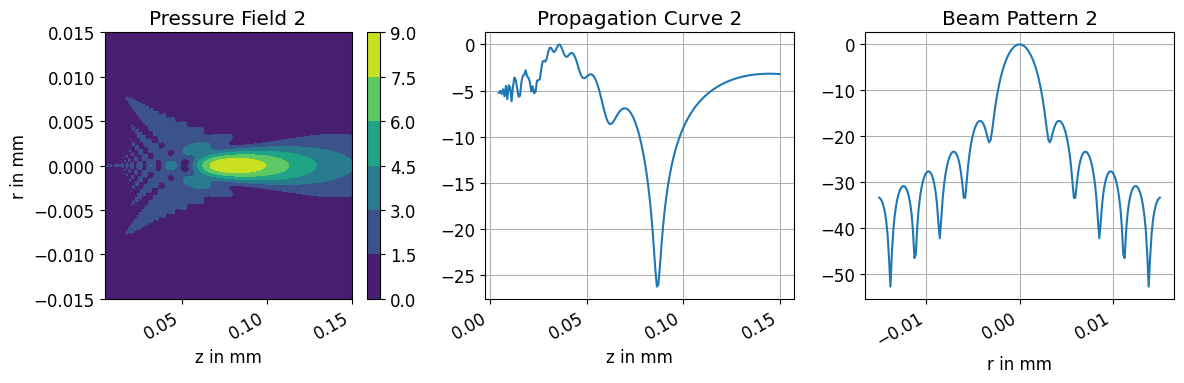

In [6]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size':12})
plt.subplot(131)
plt.contourf(z2, r2, field2)
plt.colorbar()
plt.title('Pressure Field 2')
plt.ylabel("r in mm")
plt.xlabel("z in mm")

plt.subplot(132)
plt.plot(z2, 20*np.log10(pcurve2/pcurve2.max()))
plt.title('Propagation Curve 2')
plt.grid(which='both')
plt.xlabel("z in mm")

plt.subplot(133)
plt.plot(r2, 20*np.log10(bcurve2/bcurve2.max()))
plt.title('Beam Pattern 2')
plt.grid(which='both')
plt.xlabel("r in mm")
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [7]:
# Gives Propagation Curve at r = 0, no integration required
def propagation(a, c, freq, scale):
    #absorption=0.5*100*(freq/1e6)/8.686 # first value in dB/cm/MHz
    absorption=0.0 # use this to remove the effect of absorption
    p0 = 1 #pressure in MPa or enter 1 to have p/p0

    # Calculate Rayleigh distance
    wavelength = c/freq
    R0 = (np.pi*(a**2))/wavelength
    k = 2*np.pi / wavelength

    #plot start and end points
    xstart = 4e-4 # avoid going to x=0, kzk singularity
    xmax = scale*R0
    xinc = R0/5000
    px = np.arange(xstart, xmax, xinc)
    ymax = 2.1*p0

    #main equation to plot
    p_curve = p0*np.exp(-absorption*px)*abs(2*np.sin(R0/(2*px)))

    return R0, px, p_curve

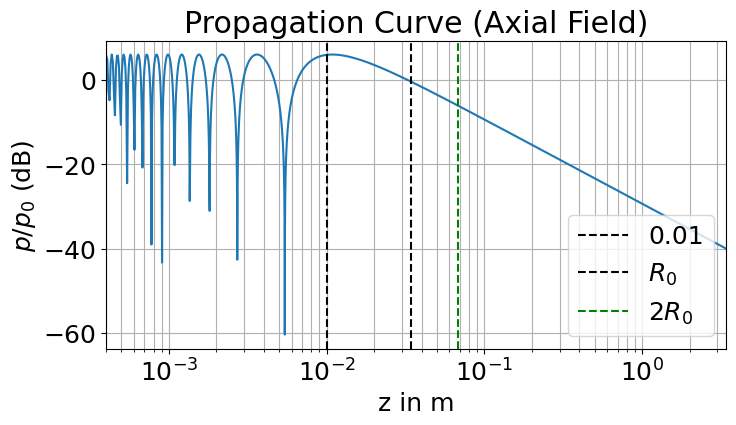

In [8]:
a=0.0254/2
c=1486
freq=0.1e6
scale=100

R0, px, p_curve = propagation(a, c, freq, scale)
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size':18})
plt.title("Propagation Curve (Axial Field)")
plt.plot(px,20*np.log10(p_curve))
plt.xlim(4e-4, scale*R0)
plt.axvline(x=0.01, color='k', linestyle='dashed', label='0.01')
plt.axvline(x=R0, color='k', linestyle='dashed', label='$R_0$')
plt.axvline(x=2*R0, color='g', linestyle='dashed', label='2$R_0$')
plt.grid(which='both')
plt.xlabel('z in m')
plt.ylabel('$p/p_0$ (dB)')
plt.xscale('log')
plt.legend(loc=4)
plt.show()

In [7]:
# Gives Beam Pattern at z = pR0*R0, no integration required
def beam_pattern(a, c, freq, pR0):
    #absorption=0.5*100*(freq/1e6)/8.686 # first value in dB/cm/MHz
    absorption=0.0 # use this to remove the effect of absorption
    p0 = 1 #pressure in MPa or enter 1 to have p/p0

    # Calculate Rayleigh distance
    wavelength = c/freq
    R0 = (np.pi*(a**2))/wavelength
    k = 2*np.pi / wavelength
    
    z=pR0*R0
    xstart=(-a/0.2)*(z/R0) # I use the z/R0 scaling to expand the x axis w distance
    xmax=(a/0.2)*(z/R0)
    xinc=a/1000
    bx=np.arange(xstart, xmax, xinc)
    argb=2*R0/(z*a)

    # adjust for amplitude when beam pattern is beyond 1*R0
    amplitude=p0*np.exp(-absorption*z)*abs(2*np.sin(R0/(2*z))) 
    b_pat=amplitude*abs(2*special.jv(1,argb*bx)/(argb*bx));

    return R0, bx, b_pat

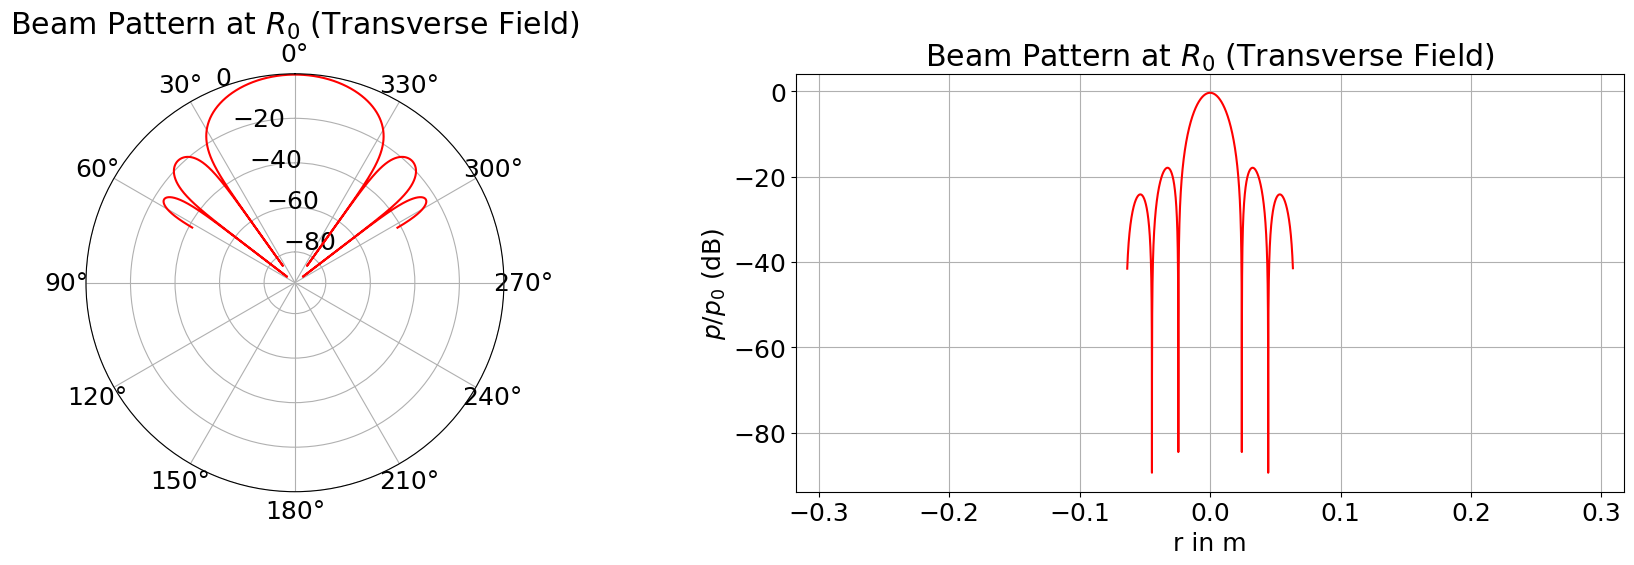

In [8]:
R0, bx, b_pat = beam_pattern(a, c, freq, 1)
radians = (np.arctan(bx/R0))
plt.figure(figsize=(18,6))
a0 = plt.subplot(121, projection='polar')
plt.title(f"Beam Pattern at $R_0$ (Transverse Field)")
plt.plot(radians, 20*np.log10(b_pat), color='r')
plt.xticks(np.arange(0,2*np.pi,np.pi/6))
a0.set_theta_zero_location('N')


plt.subplot(122)
plt.title(f"Beam Pattern at $R_0$ (Transverse Field)")
plt.plot(bx,20*np.log10(b_pat), 'r')
plt.xlim((-a/0.2)*5, (a/0.2)*5)
plt.grid(which='both')
plt.xlabel('r in m')
plt.ylabel('$p/p_0$ (dB)')

plt.tight_layout()
plt.show()

In [13]:
theta = np.linspace(-np.pi, np.pi, 10000)
theta = theta.reshape(theta.shape[0], 1)
wavelength = 343 / 40e3
k = 2*np.pi/wavelength
a = np.arange(0.002, 0.01, 0.002)
a = a.reshape(1, a.shape[0])
# a = 0.009
props = np.round(k*a, 1)[0]
labs = []
for p in props:
    labs += [f'$ka$ = {p}']

D_theta = 2*special.j1(k*a*np.sin(theta))/(k*a*np.sin(theta))
D_theta_dB = 20*np.log10(np.abs(D_theta))
clipped_D_theta_dB = np.clip(D_theta_dB, -40, None)

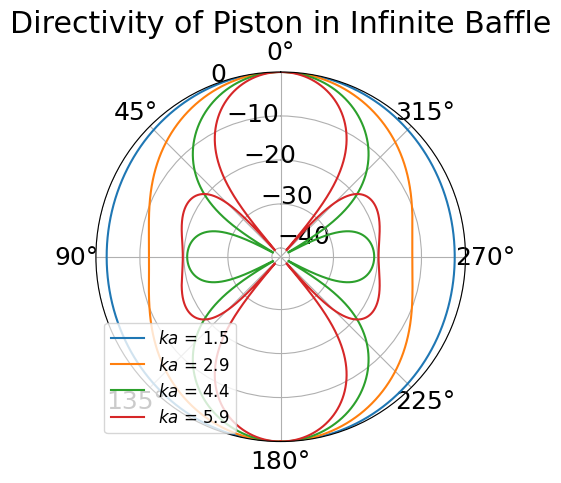

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title(f"Directivity of Piston in Infinite Baffle")
ax.plot(theta, clipped_D_theta_dB)
ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
ax.set_theta_zero_location('N')

ax.legend(labs, loc=3, fontsize=12)
plt.show()